From https://www.kaggle.com/chauhuynh/my-first-kernel-3-699

**FEEL FREE TO UPVOTE** 

In [1]:
import numpy as np
import pandas as pd
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
np.random.seed(4590)

In [2]:
file_path = 'F:/github_me_repos/Kaggle_code/elo-merchant-category-recommendation/'

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

print('finished!')

finished!


In [4]:
df_train = pd.read_csv(file_path + 'data/train.csv')
df_test = pd.read_csv(file_path + 'data/test.csv')
df_hist_trans = pd.read_csv(file_path + 'data/historical_transactions.csv')
df_new_merchant_trans = pd.read_csv(file_path + 'data/new_merchant_transactions.csv')

print('finished!')

finished!


In [5]:
for df in [df_hist_trans,df_new_merchant_trans]:
    df['category_2'].fillna(1.0,inplace=True)
    df['category_3'].fillna('A',inplace=True)
    df['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)
    
print('finished!')

finished!


In [6]:
def get_new_columns(name,aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

In [7]:
for df in [df_hist_trans, df_new_merchant_trans]:
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['year'] = df['purchase_date'].dt.year
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['month'] = df['purchase_date'].dt.month
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    df['hour'] = df['purchase_date'].dt.hour
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0})
    #https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/73244
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']


df_hist_trans = reduce_mem_usage(df_hist_trans)
df_new_merchant_trans = reduce_mem_usage(df_new_merchant_trans)
    
print('finished!')

Mem. usage decreased to 1582.53 Mb (65.2% reduction)
Mem. usage decreased to 102.97 Mb (66.5% reduction)
finished!


In [8]:
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']

aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['authorized_flag'] = ['sum', 'mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

for col in ['category_2','category_3']:
    df_hist_trans[col+'_mean'] = df_hist_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']
    
df_hist_trans = reduce_mem_usage(df_hist_trans)

new_columns = get_new_columns('hist',aggs)
df_hist_trans_group = df_hist_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['hist_purchase_date_diff'] = (df_hist_trans_group['hist_purchase_date_max'] - df_hist_trans_group['hist_purchase_date_min']).dt.days
df_hist_trans_group['hist_purchase_date_average'] = df_hist_trans_group['hist_purchase_date_diff']/df_hist_trans_group['hist_card_id_size']
df_hist_trans_group['hist_purchase_date_uptonow'] = (datetime.datetime.today() - df_hist_trans_group['hist_purchase_date_max']).dt.days
df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group;gc.collect()

print('finished!')

Mem. usage decreased to 1693.59 Mb (6.2% reduction)
finished!


In [9]:
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']
aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

for col in ['category_2','category_3']:
    df_new_merchant_trans[col+'_mean'] = df_new_merchant_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']
    
new_columns = get_new_columns('new_hist',aggs)
df_hist_trans_group = df_new_merchant_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['new_hist_purchase_date_diff'] = (df_hist_trans_group['new_hist_purchase_date_max'] - df_hist_trans_group['new_hist_purchase_date_min']).dt.days
df_hist_trans_group['new_hist_purchase_date_average'] = df_hist_trans_group['new_hist_purchase_date_diff']/df_hist_trans_group['new_hist_card_id_size']
df_hist_trans_group['new_hist_purchase_date_uptonow'] = (datetime.datetime.today() - df_hist_trans_group['new_hist_purchase_date_max']).dt.days
df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group;
gc.collect()


print('finished!')

finished!


In [10]:
# features added by tsg
# 最近三个月 最近半年 最近一年的 购买次数 购买金额 F M
# 购买的星期几占比ratio
# 购买的 Morning Afternoon Evening Night占比
print('shape is ', df_hist_trans.shape, df_new_merchant_trans.shape)

aggs = {
    'month_lag': ['size'],
#     'purchase_amount': ['sum', 'max', 'min', 'mean', 'var'],
    'purchase_amount': ['sum']
}

df_trans_month_lag = pd.concat([df_hist_trans[['card_id', 'month_lag', 'purchase_amount']], 
                                df_new_merchant_trans[['card_id', 'month_lag', 'purchase_amount']]])

del df_hist_trans;gc.collect()
del df_new_merchant_trans;gc.collect()

print('after concat df_trans_month_lag.shape is ', df_trans_month_lag.shape)

df_3_month_lag = (df_trans_month_lag[df_trans_month_lag['month_lag']<=3].
                   groupby('card_id').agg(aggs))
df_3_month_lag.columns = ['3_month_' + '_'.join(col).strip() for col in df_3_month_lag.columns.values]
df_3_month_lag.reset_index(inplace=True)
print('df_3_month_lag.shape is', df_3_month_lag.shape)


df_6_month_lag = (df_trans_month_lag[df_trans_month_lag['month_lag']<=6].
                   groupby('card_id').agg(aggs))
df_6_month_lag.columns = ['6_month_' + '_'.join(col).strip() for col in df_6_month_lag.columns.values]
df_6_month_lag.reset_index(inplace=True)
print('df_6_month_lag.shape is', df_6_month_lag.shape)


df_12_month_lag = (df_trans_month_lag[df_trans_month_lag['month_lag']<=6].
                   groupby('card_id').agg(aggs))
df_12_month_lag.columns = ['12_month_' + '_'.join(col).strip() for col in df_12_month_lag.columns.values]
df_12_month_lag.reset_index(inplace=True)
print('df_12_month_lag.shape is', df_12_month_lag.shape)

shape is  (29112361, 23) (1963031, 23)
after concat df_trans_month_lag.shape is  (31075392, 3)
df_3_month_lag.shape is (325540, 3)
df_6_month_lag.shape is (325540, 3)
df_12_month_lag.shape is (325540, 3)


In [11]:
print('df_train.columns is', df_train.columns)
print('df_test.columns is', df_test.columns)

df_train = df_train.merge(df_3_month_lag,on='card_id',how='left')
df_test = df_test.merge(df_3_month_lag,on='card_id',how='left')

df_train = df_train.merge(df_6_month_lag,on='card_id',how='left')
df_test = df_test.merge(df_6_month_lag,on='card_id',how='left')

df_train = df_train.merge(df_12_month_lag, on='card_id',how='left')
df_test = df_test.merge(df_12_month_lag, on='card_id',how='left')

print('df_train.columns is', df_train.columns)
print('df_test.columns is', df_test.columns)

df_train.columns is Index(['first_active_month', 'card_id', 'feature_1', 'feature_2', 'feature_3',
       'target', 'hist_month_nunique', 'hist_hour_nunique',
       'hist_weekofyear_nunique', 'hist_dayofweek_nunique',
       'hist_year_nunique', 'hist_subsector_id_nunique',
       'hist_merchant_id_nunique', 'hist_merchant_category_id_nunique',
       'hist_purchase_amount_sum', 'hist_purchase_amount_max',
       'hist_purchase_amount_min', 'hist_purchase_amount_mean',
       'hist_purchase_amount_var', 'hist_installments_sum',
       'hist_installments_max', 'hist_installments_min',
       'hist_installments_mean', 'hist_installments_var',
       'hist_purchase_date_max', 'hist_purchase_date_min',
       'hist_month_lag_max', 'hist_month_lag_min', 'hist_month_lag_mean',
       'hist_month_lag_var', 'hist_month_diff_mean',
       'hist_authorized_flag_sum', 'hist_authorized_flag_mean',
       'hist_weekend_sum', 'hist_weekend_mean', 'hist_category_1_sum',
       'hist_category_1_mean'

In [12]:
del df_trans_month_lag, df_3_month_lag, df_6_month_lag, df_12_month_lag;
gc.collect()

print('finished!')

finished!


In [13]:
df_train['outliers'] = 0
df_train.loc[df_train['target'] < -30, 'outliers'] = 1
df_train['outliers'].value_counts()

print('finished!')

finished!


In [14]:
for df in [df_train,df_test]:
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['dayofweek'] = df['first_active_month'].dt.dayofweek
    df['weekofyear'] = df['first_active_month'].dt.weekofyear
    df['month'] = df['first_active_month'].dt.month
    df['elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_hist_first_buy'] = (df['new_hist_purchase_date_min'] - df['first_active_month']).dt.days
    for f in ['hist_purchase_date_max','hist_purchase_date_min','new_hist_purchase_date_max',\
                     'new_hist_purchase_date_min']:
        df[f] = df[f].astype(np.int64) * 1e-9
    df['card_id_total'] = df['new_hist_card_id_size']+df['hist_card_id_size']
    df['purchase_amount_total'] = df['new_hist_purchase_amount_sum']+df['hist_purchase_amount_sum']

for f in ['feature_1','feature_2','feature_3']:
    order_label = df_train.groupby([f])['outliers'].mean()
    df_train[f] = df_train[f].map(order_label)
    df_test[f] = df_test[f].map(order_label)
    
print('finished!')

finished!


In [15]:
df_train_columns = [c for c in df_train.columns if c not in ['card_id', 'first_active_month','target','outliers']]
target = df_train['target']
del df_train['target']

print('finished!')

finished!


In [19]:
# RANDOM_STATE_TSG = 10007
RANDOM_STATE_TSG = 42
# 

param = {'num_leaves': 31, 
         'min_data_in_leaf': 30, 
         'objective':'regression', 
         'max_depth': -1, 
         'learning_rate': 0.01, 
         "min_child_samples": 20, 
         "boosting": "gbdt", 
         "feature_fraction": 0.9, 
         "bagging_freq": 1, 
         "bagging_fraction": 0.9,
         "bagging_seed": 11, 
         "metric": 'rmse',
         "lambda_l1": 0.1, 
         "verbosity": -1, 
         "nthread": 4, 
         "random_state": RANDOM_STATE_TSG
}

# final rmse is  3.6531506032733994
# final rmse is  3.652673988138324

# final rmse is  3.650857717994587
# final rmse is  3.653309736443399
# final rmse is  3.6520768276816074

#----------------------------------------------------------------

# param = {'num_leaves': 31,
#          'min_data_in_leaf': 30, 
#          'objective':'regression',
#          'max_depth': -1,
#          'learning_rate': 0.007,
#          "min_child_samples": 20,
#          "boosting": "gbdt",
#          "feature_fraction": 0.9,
#          "bagging_freq": 1,
#          "bagging_fraction": 0.9 ,
#          "bagging_seed": 11,
#          "metric": 'rmse',
#          "lambda_l1": 0.1,
#          "verbosity": -1,
#          "nthread": 4,
#          "random_state": 2019}
# final rmse is  3.653225305416142

#----------------------------------------------------------------

# param = {'num_leaves': 23,
#          'min_data_in_leaf': 31, 
#          'objective':'regression',
#          'max_depth': -1,
#          'learning_rate': 0.005,
#          "boosting": "gbdt",
#          "feature_fraction": 0.9,
#          "bagging_freq": 1,
#          "bagging_fraction": 0.9 ,
#          "bagging_seed": 11,
#          "metric": 'rmse',
#          "lambda_l1": 0.21,
#          "verbosity": -1,
#          "nthread": 4,
#          "random_state": 2019}
# final rmse is  3.6525831052105073

#----------------------------------------------------------------

# param = {'num_leaves': 37,
#          'min_data_in_leaf': 31, 
#          'objective':'regression',
#          'max_depth': -1,
#          'learning_rate': 0.01,
#          "boosting": "dart",
#          "feature_fraction": 0.9,
#          "bagging_freq": 1,
#          "bagging_fraction": 0.9 ,
#          "bagging_seed": 11,
#          "metric": 'rmse',
#          "lambda_l1": 0.21,
#          "verbosity": -1,
#          "nthread": 4,
#          "random_state": 2019}
# final rmse is  3.6582834308270673

#----------------------------------------------------------------

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE_TSG)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds=200)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

final_rmse = np.sqrt(mean_squared_error(oof, target))
print('final rmse is ', final_rmse)

sub_df = pd.DataFrame({"card_id": df_test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv(file_path + '/submission/submission_first_kernel.csv', index=False)

print('finished!')

fold 0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.66284	valid_1's rmse: 3.72329
[200]	training's rmse: 3.58411	valid_1's rmse: 3.69892
[300]	training's rmse: 3.53506	valid_1's rmse: 3.69033
[400]	training's rmse: 3.49821	valid_1's rmse: 3.68564
[500]	training's rmse: 3.46778	valid_1's rmse: 3.68307
[600]	training's rmse: 3.44249	valid_1's rmse: 3.68128
[700]	training's rmse: 3.41976	valid_1's rmse: 3.68025
[800]	training's rmse: 3.39863	valid_1's rmse: 3.67995
[900]	training's rmse: 3.37998	valid_1's rmse: 3.67997
[1000]	training's rmse: 3.36275	valid_1's rmse: 3.67968
[1100]	training's rmse: 3.34622	valid_1's rmse: 3.67947
[1200]	training's rmse: 3.32918	valid_1's rmse: 3.6794
[1300]	training's rmse: 3.31393	valid_1's rmse: 3.67987
Early stopping, best iteration is:
[1150]	training's rmse: 3.33744	valid_1's rmse: 3.6793
fold 1
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.66488	valid_1's rmse: 3.717

finished!


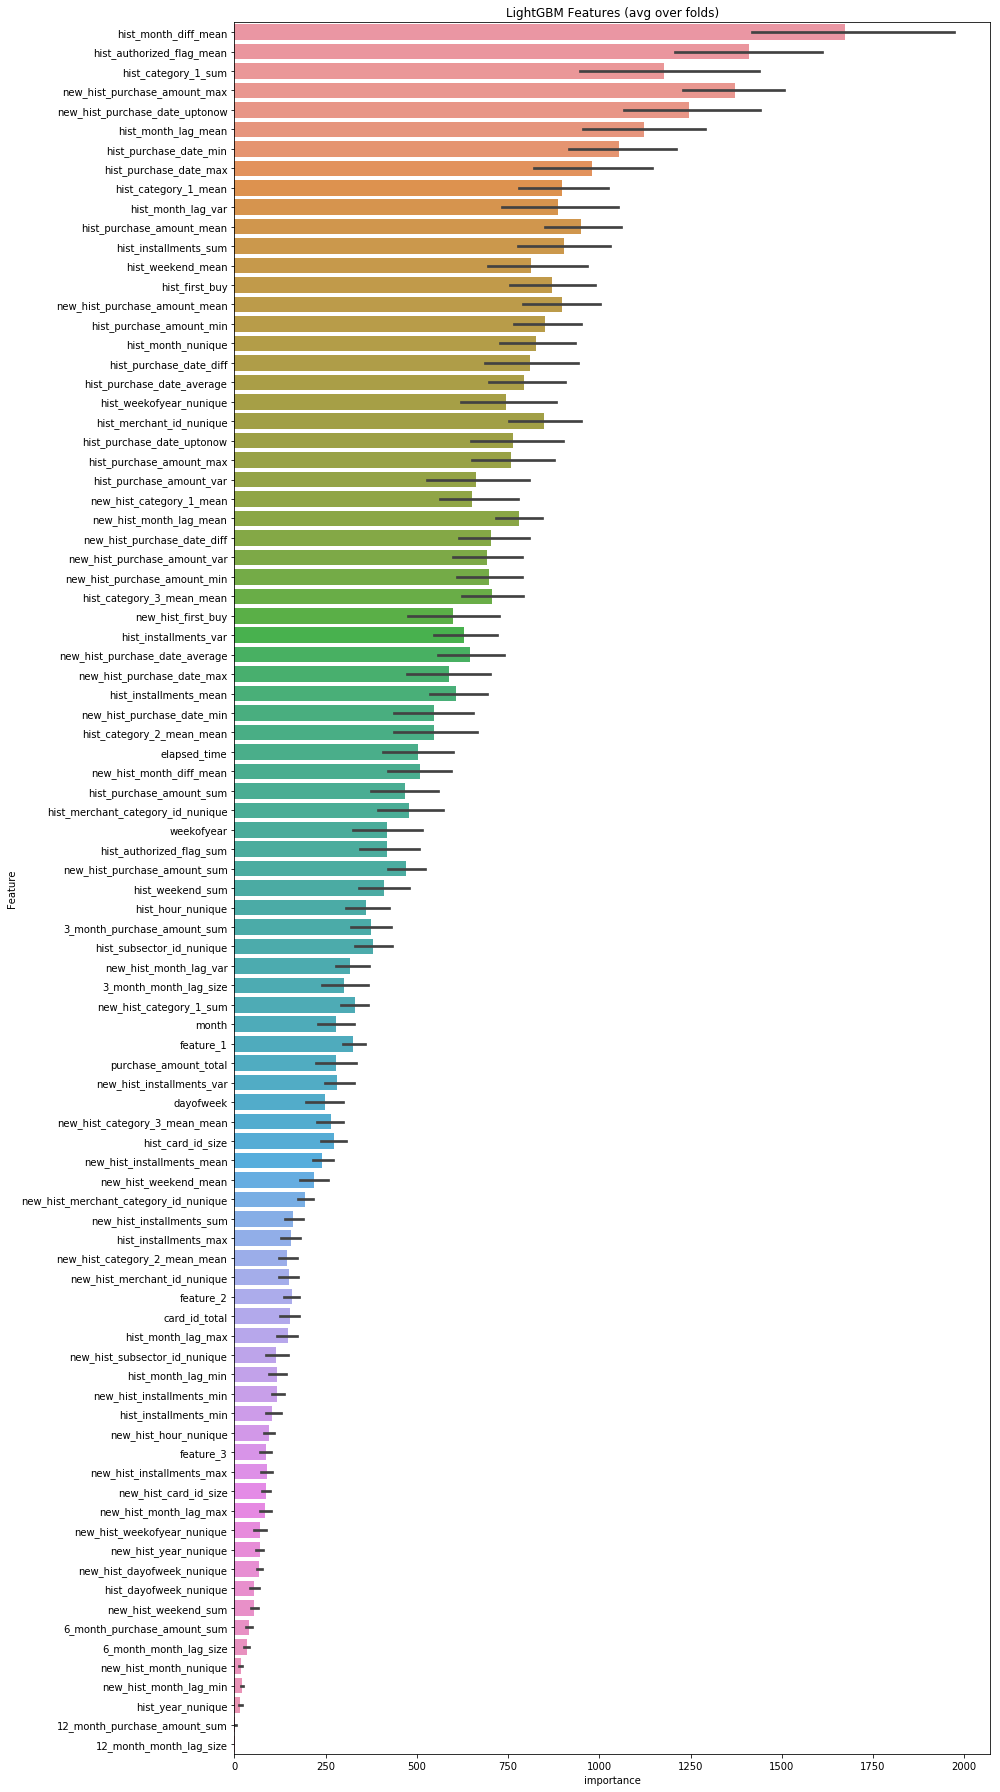

In [17]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

print('finished!')

In [18]:
# sub_df = pd.DataFrame({"card_id": df_test["card_id"].values})
# sub_df["target"] = predictions
# sub_df.to_csv(file_path + '/submission/submission_first_kernel_dart.csv', index=False)
              
# print('finished!')

**To be continued ...**